In [1]:
import pandas as pd
import numpy as np
import random
from itertools import combinations

import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

# Data Load

In [ ]:
df = pd.read_excel('./data/WholeSpine700.xlsx')
df 

,Reports,GT_label
0,Clinical information: Medulloblastoma \n \nWh...,no
1,EXAM: Whole spine MRI with contrast enhancemen...,mets
2,EXAM : Whole spine enhanced MRI with tumor pro...,progression
3,\n\nEXAM: Whole spine MRI with enhancement. \n...,no
4,\n\nEXAM: Whole spine contrast enhanced MRI \...,stable
...,...,...
695,EXAM : Whole spine MRI with contrast enhanceme...,no
696,Exam : Whole spine MR with contrast enhancemen...,no
697,\nExam: Whole-spine MRI with contrast enhancem...,romets
698,Exam: Whole-spine MRI with contrast enhancemen...,progression


In [23]:
for i, label in enumerate(df['GT_label']):
    if label == 'no ' or label == 'No':
        df['GT_label'][i] = 'no'

In [25]:
df['GT_label'].value_counts()

GT_label
stable         124
progression    121
mets           120
no             114
romets         111
improved       110
Name: count, dtype: int64

In [26]:
# 컬럼 이름 변경
df.rename(columns={'GT_label': 'label'}, inplace=True)

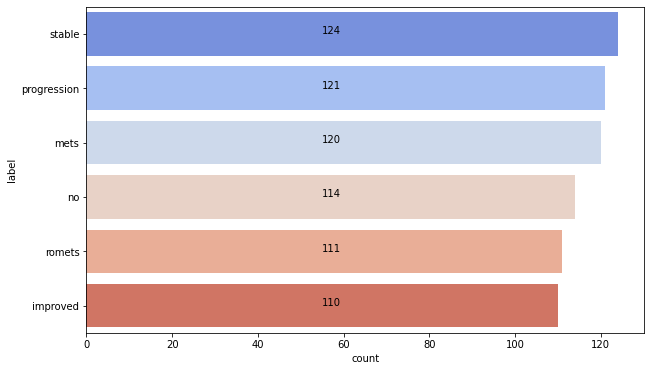

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index, palette='coolwarm')

for index, value in enumerate(df['label'].value_counts()):
    plt.text(55, index, value)

In [8]:
data = df.sort_values(by='GT_label')
data

,Reports,GT_label
496,EXAM: Whole spine MRI with contrast enhancemen...,improved
344,\n \nEXAM : Whole spine MRI with contrast enha...,improved
343,\n\nExam : Whole spine MRI with contrast enhan...,improved
194,\nEXAM : Whole-spine MRI with contrast enhance...,improved
195,EXAM: Whole-spine MRI with contrast enhancemen...,improved
...,...,...
213,\n \nEXAM: Whole-spine MRI with contrast enha...,stable
212,Exam : Whole spine MRI with contrast enhanceme...,stable
211,EXAM: Whole spine MRI with contrast enhancemen...,stable
221,Exam : Whole spine MRI with contrast enhanceme...,stable


In [9]:
stable = data[data['GT_label']=='stable'].reset_index(drop=True)
progression = data[data['GT_label']=='progression'].reset_index(drop=True)
mets = data[data['GT_label']=='mets'].reset_index(drop=True)
no = data[data['GT_label']=='no'].reset_index(drop=True)
romets = data[data['GT_label']=='romets'].reset_index(drop=True)
improved = data[data['GT_label']=='improved'].reset_index(drop=True)

In [10]:
len(stable), len(progression), len(mets), len(no), len(romets), len(improved)

(124, 121, 120, 114, 111, 110)

In [11]:
df['GT_label'].value_counts()

GT_label
stable         124
progression    121
mets           120
no             114
romets         111
improved       110
Name: count, dtype: int64

In [12]:
def create_negative_pairs(anchor_df, others_df):
    negative_pairs = []
    
    for other in others_df:
        min_len = min(len(anchor_df), len(other))
        # sample_idx = random.sample(range(min_len), 60)
        sample_idx = random.sample(range(min_len), 80)
        for i in sample_idx:
            for j in sample_idx:
                negative_pairs.append({
                    'Report1': anchor_df['Reports'][i],
                    'Report2': other['Reports'][j],
                    'label_name': anchor_df['GT_label'][0] + ' vs ' + other['GT_label'][0],
                    'label': 0
                })
            
    return negative_pairs

negative_pairs = create_negative_pairs(stable, [progression, mets, no, romets, improved])
negative_pairs += create_negative_pairs(progression, [mets, no, romets, improved])
negative_pairs += create_negative_pairs(mets, [no, romets, improved])
negative_pairs += create_negative_pairs(no, [romets, improved])
negative_pairs += create_negative_pairs(romets, [improved])

negative_pairs_df = pd.DataFrame(negative_pairs)
negative_pairs_df

,Report1,Report2,label_name,label
0,\n\nExam: Whole spine MR with contrast enhance...,\n \nEXAM: Whole spine contrast enhanced MRI ...,stable vs progression,0
1,\n\nExam: Whole spine MR with contrast enhance...,EXAM: Whole spine contrast enhanced MRI. ...,stable vs progression,0
2,\n\nExam: Whole spine MR with contrast enhance...,EXAMINATION: Whole spine MRI with contrast en...,stable vs progression,0
3,\n\nExam: Whole spine MR with contrast enhance...,"Clinical information: Prostate Cancer, metasta...",stable vs progression,0
4,\n\nExam: Whole spine MR with contrast enhance...,\n \nEXAM: Whole spine MRI with enhancement. \...,stable vs progression,0
...,...,...,...,...
95995,\nExam: Whole spine MRI with contrast enhancem...,EXAM: Whole spine MRI with contrast enhancemen...,romets vs improved,0
95996,\nExam: Whole spine MRI with contrast enhancem...,EXAM: Whole-spine MRI with contrast enhancemen...,romets vs improved,0
95997,\nExam: Whole spine MRI with contrast enhancem...,\n \nEXAM : Whole-spine MRI with contrast enh...,romets vs improved,0
95998,\nExam: Whole spine MRI with contrast enhancem...,\n \nEXAM: Whole-spine MRI with contrast enhan...,romets vs improved,0


In [13]:
from itertools import combinations

label_df = [stable, progression, mets, no, romets, improved]
def create_positive_pairs(label_df):
    postiive_pairs = []
    
    for label in label_df:
        label_combinations = list(combinations(label['Reports'], 2))
        for comb in label_combinations:
            postiive_pairs.append({
                'Report1': comb[0],
                'Report2': comb[1],
                'label_name' : label['GT_label'][0] + ' vs ' + label['GT_label'][0],
                'label': 1
            })
            
    return postiive_pairs
        
positive_pairs = create_positive_pairs(label_df)
positive_pairs_df = pd.DataFrame(positive_pairs)
positive_pairs_df

,Report1,Report2,label_name,label
0,\n\nExam : Whole spine MRI with contrast enhan...,\n \nEXAM : Whole spine MRI with contrast enha...,stable vs stable,1
1,\n\nExam : Whole spine MRI with contrast enhan...,Exam: Whole spine MRI with contrast enhancemen...,stable vs stable,1
2,\n\nExam : Whole spine MRI with contrast enhan...,EXAM: Whole spine MRI with contrast enhancemen...,stable vs stable,1
3,\n\nExam : Whole spine MRI with contrast enhan...,EXAM: Whole spine MRI with contrast enhancemen...,stable vs stable,1
4,\n\nExam : Whole spine MRI with contrast enhan...,\n \nExam: Whole spine MRI with contrast enhan...,stable vs stable,1
...,...,...,...,...
40562,\nEXAM: Whole spine MRI with contrast enhancem...,\n\nEXAM : Whole-spine MRI with contrast enhan...,improved vs improved,1
40563,\nEXAM: Whole spine MRI with contrast enhancem...,EXAM: Whole spine MRI with contrast enhancemen...,improved vs improved,1
40564,EXAM: Whole spine MRI with contrast enhancment...,\n\nEXAM : Whole-spine MRI with contrast enhan...,improved vs improved,1
40565,EXAM: Whole spine MRI with contrast enhancment...,EXAM: Whole spine MRI with contrast enhancemen...,improved vs improved,1


In [14]:
pairs_df = pd.concat([positive_pairs_df, negative_pairs_df]).reset_index(drop=True)
display(pairs_df)
display(pairs_df.label.value_counts())
display(pairs_df.label_name.value_counts())

,Report1,Report2,label_name,label
0,\n\nExam : Whole spine MRI with contrast enhan...,\n \nEXAM : Whole spine MRI with contrast enha...,stable vs stable,1
1,\n\nExam : Whole spine MRI with contrast enhan...,Exam: Whole spine MRI with contrast enhancemen...,stable vs stable,1
2,\n\nExam : Whole spine MRI with contrast enhan...,EXAM: Whole spine MRI with contrast enhancemen...,stable vs stable,1
3,\n\nExam : Whole spine MRI with contrast enhan...,EXAM: Whole spine MRI with contrast enhancemen...,stable vs stable,1
4,\n\nExam : Whole spine MRI with contrast enhan...,\n \nExam: Whole spine MRI with contrast enhan...,stable vs stable,1
...,...,...,...,...
136562,\nExam: Whole spine MRI with contrast enhancem...,EXAM: Whole spine MRI with contrast enhancemen...,romets vs improved,0
136563,\nExam: Whole spine MRI with contrast enhancem...,EXAM: Whole-spine MRI with contrast enhancemen...,romets vs improved,0
136564,\nExam: Whole spine MRI with contrast enhancem...,\n \nEXAM : Whole-spine MRI with contrast enh...,romets vs improved,0
136565,\nExam: Whole spine MRI with contrast enhancem...,\n \nEXAM: Whole-spine MRI with contrast enhan...,romets vs improved,0


label
0    96000
1    40567
Name: count, dtype: int64

label_name
stable vs stable              7626
progression vs progression    7260
mets vs mets                  7140
no vs no                      6441
progression vs no             6400
no vs improved                6400
no vs romets                  6400
mets vs improved              6400
mets vs romets                6400
mets vs no                    6400
progression vs improved       6400
progression vs romets         6400
stable vs improved            6400
progression vs mets           6400
stable vs romets              6400
stable vs no                  6400
stable vs mets                6400
stable vs progression         6400
romets vs improved            6400
romets vs romets              6105
improved vs improved          5995
Name: count, dtype: int64

In [188]:
# train test split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(pairs_df, test_size=0.2, random_state=42, stratify=pairs_df['label_name'])
print(f'훈련 데이터셋 수 : {len(train_data)}')
print(f'테스트 데이터셋 수 : {len(test_data)}')

훈련 데이터셋 수 : 75653
테스트 데이터셋 수 : 18914


In [189]:
train_data.drop(['label_name'], axis=1, inplace=True)
test_data.drop(['label_name'], axis=1, inplace=True)

In [ ]:
train_data.to_csv('./data/siamese/train_data.csv', index=False)
test_data.to_csv('./data/siamese/test_data.csv', index=False)

In [ ]:
train_data = pd.read_csv('./data/siamese/train_data.csv')   
train_data

,Report1,Report2,label
0,\n \nExam : Whole-spine MRI with contrast enh...,EXAM : Whole spine MRI with enhancement.\n\nCl...,0
1,"Clinical information: Melanoma, metastatic\nFi...",EXAM : Whole spine MRI with contrast enhancem...,0
2,EXAM Whole spine MRI with contrast enhancement...,\n\nEXAM: Whole spine MRI with contrast enhanc...,1
3,EXAM : Whole spine MRI with contrast enhanceme...,\n\nEXAM : Whole spine MRI and diffusion weigh...,1
4,Exam: T-spine MRI without contrast enhancement...,\n\nEXAM: Whole spine MRI with enhancement. \n...,0
...,...,...,...
75648,\n\nClinical information: Left breast cancer s...,\n\nExam: Whole spine MRI with contrast enhanc...,1
75649,EXAM : Whole-spine contrast enhanced MRI. \n\...,Exam: Whole spine MRI with contrast enhancemen...,0
75650,\n\nEXAM: Whole spine contrast enhanced MRI of...,Exam: Whole-spine MRI with enhancement.\nClini...,1
75651,EXAM: Whole spine MRI with contrast enhancemen...,\n\nEXAM : Whole-spine MRI with contrast enhan...,1


# Train Test Split

In [31]:
# train test split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=821, stratify=data['GT_label'])
print(f'훈련 데이터셋 수 : {len(train_data)}')
print(f'테스트 데이터셋 수 : {len(test_data)}')

훈련 데이터셋 수 : 560
테스트 데이터셋 수 : 140


In [32]:
data['GT_label'].unique()

array(['improved', 'mets', 'no', 'progression', 'romets', 'stable'],
      dtype=object)

In [33]:
import warnings
warnings.filterwarnings('ignore')

num_labels = {'no':0, 'mets':1, 'progression':2, 'stable':3, 'improved':4, 'romets':5}
train_data["label"] = 0
test_data["label"] = 0

for keyStr in num_labels.keys():
    train_data["label"][train_data["GT_label"]==keyStr] = num_labels[keyStr]
    test_data["label"][test_data["GT_label"]==keyStr] = num_labels[keyStr]


In [34]:
train_df = train_data[['Reports', 'label']]
test_df = test_data[['Reports', 'label']]

display(train_df.head(), test_df.head())

,Reports,label
648,EXAM : MRI Whole-spine with contrast enhanceme...,2
261,EXAM: Whole spine MRI with contrast enhancemen...,5
141,"Clinical information: Renal Cell Carcinoma, me...",2
288,"\n \n \nClinical information : Salivary gland,...",2
432,\n\nClinical information : Thyroid cancer. \n...,1


,Reports,label
283,EXAM Whole spine contrast enhanced MRI. \n...,3
52,EXAM : Whole spine MRI with contrast enhanceme...,1
168,\n\nExam: Whole spine MRI with routine protoco...,0
174,EXAM: Whole spine MRI with contrast enhancemen...,5
371,\n\nEXAM: Whole spine MRI with contrast enhanc...,0


In [35]:
train_df['label'].value_counts()

label
3    99
2    97
1    96
0    91
5    89
4    88
Name: count, dtype: int64

In [36]:
test_df['label'].value_counts()

label
3    25
1    24
2    24
0    23
5    22
4    22
Name: count, dtype: int64

In [26]:
train_df.to_csv('./data/tumor/tumor_train.csv', index=False)
test_df.to_csv('./data/tumor/tumor_test.csv', index=False)

In [27]:
train_df = pd.read_csv('./data/tumor/tumor_train.csv')
test_df = pd.read_csv('./data/tumor/tumor_test.csv')

In [28]:
sents = train_df['Reports'].tolist()
labels = train_df['label'].tolist()

display(sents[:5], labels[:5])

['\n\nEXAM: Whole spine contrast enhanced MRI  \n\nThe patient with history of pancreatic cancer.    \n  \nFINDINGS:   \nMarrow-replacing enhancing lesions in the C, T, L- spines, sternum and iliac bones.  \nDisc bulgings with central canal narrowing in L4/5 and L5/S1.   \nNo evidence of spinal cord compression.  \n  \nCONCLUSION:  \nMultiple bone metastases. \n',
 '\n\nEXAM: Whole-spine MRI with contrast enhancement.  \nClinical information: Lung cancer on CTx.   \n  \nCompared with 2021-11-05 MRI.  \n  \nFindings:   \nNo change in size of bone marrow replacing lesion with enhancement at L1 vertebral body.   \nSclerotic lesion at T12 body. Suggesting enostosis.   \nProbably vertebral hemangioma at T5 and T7 body.   \nInterval improvement of previous suspected discitis, T6/7. \nUnremarkable finding of spinal cord.   \n   \nConclusion:   \nNo change of bone metastasis in L1 vertebral body. \nProbably vertebral hemangiomas, T5 and T7body.   \n   \nRecommendation:   \nClinical correlation

[1, 3, 5, 1, 2]